# Business Problem

SYL bank is one of Australia's largest banks. Currently, the loan applications which come in to their various branches are processed manually. The decision whether to grant a loan or not is subjective and due to a lot of applications coming in, it is getting harder for them to decide the loan grant status. Thus, they want to build an automated machine learning solution which will look at different factors and decide whether to grant loan or not to the respective individual.

In this ML problem, we will building a classification model as we have to predict if an applicant should get a loan or not. We will look at various factors of the applicant like credit score, past history and from those we will try to predict the loan granting status. We will also cleanse the data and fill in the missing values so that our ML model performs as expected. Thus we will be giving out a probability score along with Loan Granted or Loan Refused output from the model.

## Machine Learning Perspective

This business problem falls under:
- Supervised Learning
- Classification [ Binary ]

## Solution WorkFlow

- UNDERSTANDING PROBLEM STATEMENT
- SETTING UP THE WORKING ENVOIRNMENT
- DATA INGESTION / SOURCING
- EDA ( EXPLORATORY DATA ANALYSIS)
    - OUTLIER DETECTION
    - CORRELATIONS
    - MISSING VALUES
- DATA PREPARATION
- MODEL BUILDING
- MODEL EVALUATION
- FINALIZING THE MODEL AND SAVE IT
- PRODUCTIONIZATION (IN-GENERAL, NOT PERFORMED HERE)

### SETTING UP THE WORKING ENVOIRNMENT

In [118]:
# DATA MANIPULATION LIBRARIES
import pandas as pd
import numpy as np
import os

# data visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import pyplot

# sklearn - final data preparation libraries
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelBinarizer, StandardScaler, OrdinalEncoder
from sklearn import preprocessing

# imblance dataset preparation libraries
from imblearn.over_sampling import SMOTE

#model building libraries
from sklearn.linear_model import LogisticRegression, RidgeClassifier, PassiveAggressiveClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from xgboost import plot_importance


# model metrics
from sklearn.metrics import confusion_matrix,roc_curve,roc_auc_score,classification_report
from sklearn import metrics

# statistics
import statistics
from scipy.stats import boxcox

# model saving
import joblib

### DATA SOURCING

In [119]:
# Reading the dataset
data = pd.read_csv('D:\\github\\1-DataSets\\loan eligibility prediction\\LoansTrainingSetV2.csv',
                  low_memory=False)

### EDA - Exploratory Data Analysis

#### Information / summary of the data

In [120]:
# first five rows
data.head()

,Loan ID,Customer ID,Loan Status,Current Loan Amount,Term,Credit Score,Years in current job,Home Ownership,Annual Income,Purpose,Monthly Debt,Years of Credit History,Months since last delinquent,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
0,6cf51492-02a2-423e-b93d-676f05b9ad53,7c202b37-2add-44e8-9aea-d5b119aea935,Loan Refused,12232,Short Term,7280.0,< 1 year,Rent,46643.0,Debt Consolidation,777.39,18.0,10.0,12,0,6762,7946,0.0,0.0
1,552e7ade-4292-4354-9ff9-c48031697d72,e7217b0a-07ac-47dd-b379-577b5a35b7c6,Loan Refused,25014,Long Term,7330.0,10+ years,Home Mortgage,81099.0,Debt Consolidation,892.09,26.7,NaN,14,0,35706,77961,0.0,0.0
2,9b5e32b3-8d76-4801-afc8-d729d5a2e6b9,0a62fc41-16c8-40b5-92ff-9e4b763ce714,Loan Refused,16117,Short Term,7240.0,9 years,Home Mortgage,60438.0,Home Improvements,1244.02,16.7,32.0,11,1,11275,14815,1.0,0.0
3,5419b7c7-ac11-4be2-a8a7-b131fb6d6dbe,30f36c59-5182-4482-8bbb-5b736849ae43,Loan Refused,11716,Short Term,7400.0,3 years,Rent,34171.0,Debt Consolidation,990.94,10.0,NaN,21,0,7009,43533,0.0,0.0
4,1450910f-9495-4fc9-afaf-9bdf4b9821df,70c26012-bba5-42c0-8dcb-75295ada31bb,Loan Refused,9789,Long Term,6860.0,10+ years,Home Mortgage,47003.0,Home Improvements,503.71,16.7,25.0,13,1,16913,19553,1.0,0.0


In [121]:
# shape of the data
data.shape

(111107, 19)

In [122]:
# information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111107 entries, 0 to 111106
Data columns (total 19 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Loan ID                       111107 non-null  object 
 1   Customer ID                   111107 non-null  object 
 2   Loan Status                   111107 non-null  object 
 3   Current Loan Amount           111107 non-null  int64  
 4   Term                          111107 non-null  object 
 5   Credit Score                  89769 non-null   float64
 6   Years in current job          106414 non-null  object 
 7   Home Ownership                111107 non-null  object 
 8   Annual Income                 89769 non-null   float64
 9   Purpose                       111107 non-null  object 
 10  Monthly Debt                  111107 non-null  object 
 11  Years of Credit History       111107 non-null  float64
 12  Months since last delinquent  52104 non-null

#### Dropping the duplicates - "Loan ID"

In [123]:
data.drop_duplicates(subset='Loan ID',
                    keep='first',
                    inplace=True)

In [124]:
data.shape

(88910, 19)

There are about 21k records which are duplicate, which is a huge number 

#### Target Variable 

In [125]:
status = data['Loan Status'].value_counts()

In [126]:
status

Loan Given      63737
Loan Refused    25173
Name: Loan Status, dtype: int64

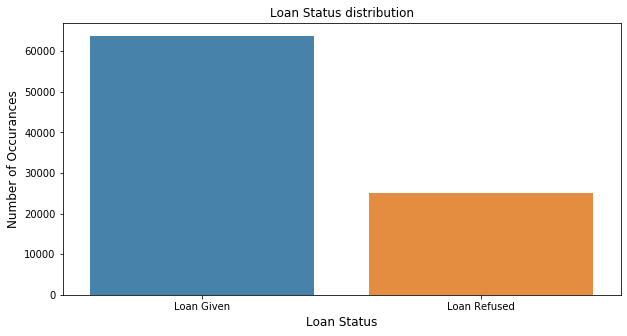

In [127]:
plt.figure(figsize=(10,5))
sns.barplot(status.index,
           status.values,
           alpha=0.9)
plt.title('Loan Status distribution')
plt.xlabel('Loan Status',fontsize=12)
plt.ylabel('Number of Occurances',fontsize=12)
plt.savefig('D:\\github\\6-Loan Eligibility Prediction\\Loan-Eligibility-Prediction-Using-Gradient-Boosting-Classifier\\plots\\1_targetVariable_Distribution.png')

We can see that ,our target variable is imbalanced

#### Attribute - Current Loan Amount

In [128]:
data['Current Loan Amount'].describe()

count    8.891000e+04
mean     1.433878e+07
std      3.502996e+07
min      4.910000e+02
25%      8.283000e+03
50%      1.435500e+04
75%      2.448500e+04
max      1.000000e+08
Name: Current Loan Amount, dtype: float64

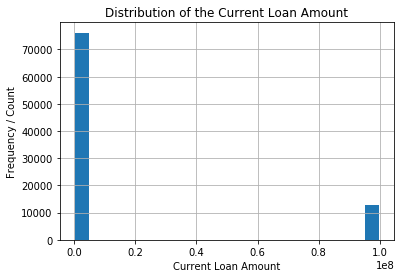

In [129]:
data['Current Loan Amount'].plot.hist(grid=True,
                                     bins=20,
                                     rwidth=0.9)
plt.title('Distribution of the Current Loan Amount')
plt.xlabel('Current Loan Amount')
plt.ylabel('Frequency / Count')
plt.savefig('D:\\github\\6-Loan Eligibility Prediction\\Loan-Eligibility-Prediction-Using-Gradient-Boosting-Classifier\\plots\\2_custLoanAmt_Distribution_outliers.png')

From this plot , we can say that there are few outliers in the data

In [130]:
# finding the outliers
q1 = data['Current Loan Amount'].quantile(0.25)
q3 = data['Current Loan Amount'].quantile(0.75)
iqr = q3 - q1
print('IQR of Current Loan Amount: ',iqr)

IQR of Current Loan Amount:  16202.0


In [131]:
# Outlier of the data
data['Current Loan Amount'][(data['Current Loan Amount'] > (iqr*1.5+q3))|(data['Current Loan Amount'] < (q1 - iqr*1.5))]

5044     99999999
5045     99999999
5046     99999999
5047     99999999
5048     99999999
           ...   
17777    99999999
17778    99999999
17779    99999999
17780    99999999
17781    99999999
Name: Current Loan Amount, Length: 12738, dtype: int64

In [132]:
# replacing all the outliers with 'NaN'
temp = np.array(data['Current Loan Amount'].values.tolist())

data['Current Loan Amount Temp'] = np.where(temp>9999998, 'NaN', temp).tolist()

FileNotFoundError: [Errno 2] No such file or directory: 'D:\\github\\6-Loan Eligibility Prediction\\Loan-Eligibility-Prediction-Using-Gradient-Boosting-Classifier\\plots\\3_custLoanAmt_Distribution_w/o_outliers.png'

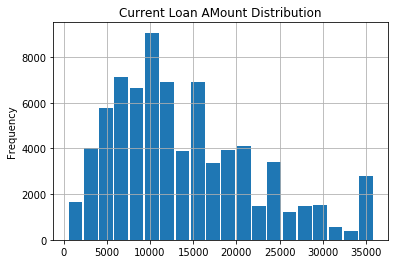

In [140]:
# getting the values which are not outliers for plotting the distribution
temp = data['Current Loan Amount Temp'][data['Current Loan Amount Temp']!='NaN'].astype(str).astype(int)

temp.plot.hist(grid=True,
              bins=20,
              rwidth=0.9)
plt.title('Current Loan AMount Distribution')
plt.savefig('D:\\github\\6-Loan Eligibility Prediction\\Loan-Eligibility-Prediction-Using-Gradient-Boosting-Classifier\\plots\\3_custLoanAmt_Distribution_w/o_outliers.png')

In [134]:
temp.describe()

count    76172.000000
mean     13933.915756
std       8235.921922
min        491.000000
25%       7810.000000
50%      12038.000000
75%      19351.000000
max      35875.000000
Name: Current Loan Amount Temp, dtype: float64

In [111]:
# replacing the outliers with median / 50% percentile value
temp = np.array(data['Current Loan Amount'].values.tolist())
data['Current Loan Amount'] = np.where(temp>9999998,12038,temp).tolist()

In [115]:
data = data.drop(['Current Loan Amount Temp'],
                axis=1)